In [64]:
from collections import deque 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from river import cluster as river_cluster
from sklearn import cluster as sklearn_cluster
from river import stream
from river.utils import dict2numpy
from collections import Counter
from tqdm import tqdm
import time

# FastCOMPOSE pipeline with improvement 1

In [65]:
class FastCOMPOSE:
    def __init__(self, data, labels, training_set_size):
        ### OK
        self.training_set_size = training_set_size
        self.training_set_data = deque()
        self.training_set_labels = deque()
        self.clusters = None
        
        for i, (x, y) in enumerate(stream.iter_array(data, labels)):
            # Add labeled data to the training set
            self._add_data_to_training_set([(x, y)])
        
        # Initial number of classes serving as lower boundary of possible number of clusters
        self.inital_number_of_classes = len(np.unique(self.training_set_labels))
        
        # Train on training set
        self._train_on_training_set(None)
            
    def _calculate_accuracy(self, data, labels):
        ### OK
        # Calculate accuracy on current batch
        accuracy = 0
        accuracy_per_class = {label: [] for label in np.unique(labels)}
            
        for i, (x, y) in enumerate(stream.iter_array(data, labels)):
            cluster = self.clustering_algorithm.predict(dict2numpy(x).reshape(1, -1))[0]
            y_pred = self.clusters[cluster]["cluster_label"]
            accuracy += (y == y_pred)
            accuracy_per_class[y].append(y == y_pred)
            
        accuracy /= len(data)
        accuracy_per_class = {label: np.mean(scores) for label, scores in accuracy_per_class.items()}
        
        return accuracy, accuracy_per_class
            
    def _add_data_to_training_set(self, labeled_data):
        ### OK
        for x, y in labeled_data:
            if self.training_set_size and len(self.training_set_data) == self.training_set_size:
                self.training_set_data.popleft()
                self.training_set_labels.popleft()
            self.training_set_data.append(dict2numpy(x))
            self.training_set_labels.append(y)
            
    def _create_clusters(self, data_from_current_batch):
        ### OK
        self.clusters = {idx: {"data": [], "labels": [], "number_of_examples_from_current_batch": 0, "cluster_label": None} for idx in range(self.n_clusters)}

        for i, (x, y) in enumerate(stream.iter_array(self.training_set_data, self.training_set_labels)):
            cluster = self.clustering_algorithm.labels_[i]
            self.clusters[cluster]["data"].append(x)
            self.clusters[cluster]["labels"].append(y)
            
            if data_from_current_batch and (x, y) in data_from_current_batch:
                self.clusters[cluster]["number_of_examples_from_current_batch"] += 1

        # Label clusters by majority voting
        for cluster_idx in self.clusters.keys():
            cluster_label = max(set(self.clusters[cluster_idx]["labels"]),
                                key=self.clusters[cluster_idx]["labels"].count)
            self.clusters[cluster_idx]["cluster_label"] = cluster_label
            
        # Retrain with smaller number of clusters if created clusters only with examples from current batch
        if np.any([len(cluster["data"]) == cluster["number_of_examples_from_current_batch"] for idx, cluster in self.clusters.items()]):
            return 1

        return 0
    
    def _train_on_training_set(self, data_from_current_batch):
        ### OK
        previous_clusters = self.clusters
        
        self.n_clusters = 5
        self.clustering_algorithm = sklearn_cluster.KMeans(n_clusters=self.n_clusters)
        
        self.clustering_algorithm = self.clustering_algorithm.fit(self.training_set_data)
        retrain = self._create_clusters(data_from_current_batch)
            
        # If some clusters contain only data from current batch retrain model with smaller number of clusters
        while retrain and self.n_clusters > self.inital_number_of_classes:
            self.n_clusters -= 1
            self.clustering_algorithm = sklearn_cluster.KMeans(n_clusters=self.n_clusters)
            
            print(f"Number of clusters = {self.n_clusters}")
            
            self.clustering_algorithm = self.clustering_algorithm.fit(self.training_set_data)
            retrain = self._create_clusters(data_from_current_batch)
            
        # If some class is going to be lost keep it in the cluster with the highest proportion of this class
        if previous_clusters:
            classes_in_current_clusters = np.unique(
                [cluster["cluster_label"] for cluster in list(self.clusters.values())])
            classes_in_previous_clusters = np.unique(
                [cluster["cluster_label"] for cluster in list(previous_clusters.values())])

            if not np.array_equal(classes_in_current_clusters, classes_in_previous_clusters) and len(self.clusters) == len(previous_clusters):
                for class_ in classes_in_previous_clusters:
                    if class_ not in classes_in_current_clusters:
                        missing_class_proportions = {idx: Counter(cluster["labels"])[class_] / len(cluster["labels"])
                                                     for idx, cluster in list(self.clusters.items())}
                        cluster_to_keep_class = max(missing_class_proportions, key=missing_class_proportions.get)
                        self.clusters[cluster_to_keep_class]["cluster_label"] = class_
            
    def _cluster_and_label_step(self, data, labels):
        ### OK
        data_with_labels = []
        
        for i, (x, _) in enumerate(stream.iter_array(data, labels)):   
            cluster = self.clustering_algorithm.predict(dict2numpy(x).reshape(1, -1))[0]
            y = self.clusters[cluster]["cluster_label"]
            data_with_labels.append((x, y))
        
        # Add newly labeled data to the training set
        self._add_data_to_training_set(data_with_labels)
        
        self._train_on_training_set(data_with_labels)
        
    def plot_clusters(self, print_label_counts_in_clusters):  
        ### OK
        data_dim = self.training_set_data[0].shape[0]
            
        # Plot 3D data
        if data_dim == 3:
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')

        for idx, cluster in self.clusters.items():
            labels = cluster["labels"]
            # Skip empty clusters
            if len(labels) == 0:
                continue
            label = cluster["cluster_label"]
            cluster = np.vstack([list(data_element.values()) for data_element in cluster["data"]])
            # Plot 3D data
            if data_dim == 3:
                ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], label=label)
            # Plot 2D data
            else:
                plt.scatter(cluster[:, 0], cluster[:, 1], label=label)
                
            if print_label_counts_in_clusters:
                counter = Counter(labels)
                print(dict(counter))
        
        plt.title("Clusters from training set with labels")
        plt.legend()
        plt.show()
                    
    def __call__(self, data, labels):
        ### OK
        self._cluster_and_label_step(data, labels)
        accuracy, accuracy_per_class = self._calculate_accuracy(data, labels)
        return accuracy, accuracy_per_class

In [66]:
def plot_incoming_data(data, labels):
    unique_labels = np.unique(labels)
    data_dim = data.shape[1]
    
    # Plot 3D data
    if data.shape[1] == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
    
    for label in unique_labels:
        # Plot 3D data
        if data_dim == 3:
            ax.scatter(data[labels == label][:, 0], data[labels == label][:, 1], data[labels == label][:, 2], label=label)
        # Plot 2D data
        else:
            plt.scatter(data[labels == label][:, 0], data[labels == label][:, 1], label=label)
    
    plt.title("Data from current batch with labels")
    plt.legend()
    plt.show()

In [67]:
def train_fast_compose(streaming_data, streaming_labels, training_set_size=1000, print_interval=50, print_label_counts_in_clusters=False):
    # Assume first batch (streaming_data[0], streaming_labels[0]) to be labelled to initialize algorithm
    accuracies = []
    accuracies_per_class = {label: [] for label in np.unique(streaming_labels)}
    start = time.time()

    fc = FastCOMPOSE(streaming_data[0], streaming_labels[0], training_set_size)

    for batch_idx, (data, labels) in tqdm(enumerate(zip(streaming_data[1:], streaming_labels[1:]), 1)):
        accuracy, accuracy_per_class = fc(data, labels)
        accuracies.append(accuracy)
        for label, accuracy in accuracy_per_class.items():
            accuracies_per_class[label].append(accuracy)
        # If class not present in current batch set accuracy for that class to None
        for label in accuracies_per_class.keys():
            if label not in accuracy_per_class.keys():
                accuracies_per_class[label].append(None)

    #     print(batch_idx, accuracy)

        if batch_idx % print_interval == 0:
            fc.plot_clusters(print_label_counts_in_clusters)
            plot_incoming_data(data, labels)

    end = time.time()
    print(f"Time elapsed: {end - start}")
    
    plt.plot(accuracies)
    plt.title("Accuracy")
    plt.show()
    
    for label, accuracy in accuracies_per_class.items():
        plt.plot(accuracy, label=f"{label}")
    plt.title("Accuracy per class")
    plt.legend()
    plt.show()
    
    return fc, accuracies, accuracies_per_class

# Experiments 2D

In [68]:
dataset_2d = "./2d_gaussian_data_v2.csv"

In [69]:
gaussian_data_2d = pd.read_csv(dataset_2d)
y_2d = gaussian_data_2d.pop('label').to_numpy()
X_2d = gaussian_data_2d.to_numpy()

In [70]:
X_2d.shape

(26300, 2)

In [71]:
y_2d.shape

(26300,)

In [72]:
for xi, yi in stream.iter_array(X_2d, y_2d):
    print(xi, yi)
    break

{0: 1.3084041099825865, 1: 5.271207619270895} 0


In [73]:
streaming_data_2d = np.split(X_2d, X_2d.shape[0]/100)
streaming_labels_2d = np.split(y_2d, y_2d.shape[0]/100)

In [74]:
streaming_data_2d[0].shape

(100, 2)

In [75]:
streaming_labels_2d[0].shape

(100,)

49it [00:12,  3.87it/s]

{0: 285, 1: 8}
{1: 386}
{0: 321}
{1: 254}
{1: 152, 0: 94}


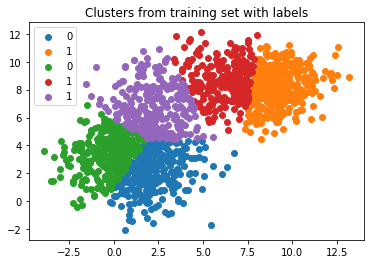

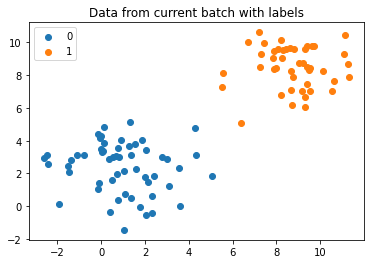

99it [00:24,  3.87it/s]

{1: 257}
{0: 279}
{1: 448}
{0: 231, 1: 2}
{1: 283}


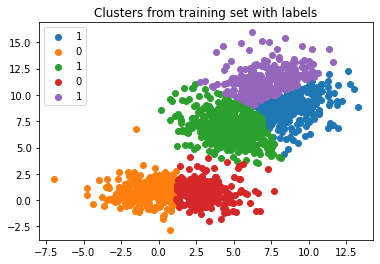

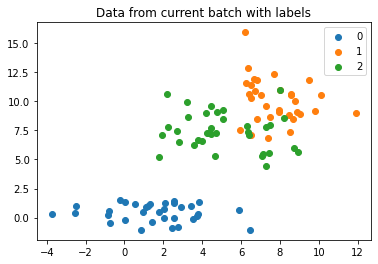

149it [00:35,  4.86it/s]

{0: 324, 1: 36}
{0: 278, 1: 4}
{0: 129}
{1: 186, 0: 27}
{1: 516}


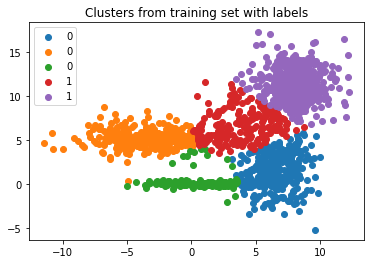

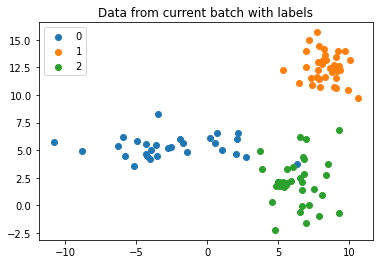

199it [00:46,  4.12it/s]

{1: 489}
{0: 292}
{0: 239}
{0: 201}
{0: 279}


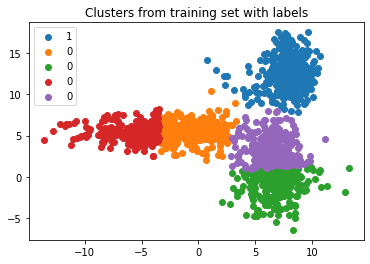

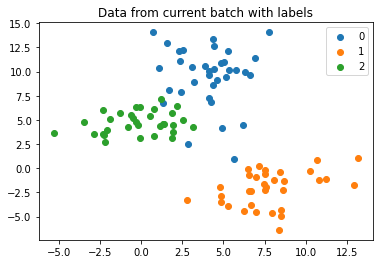

249it [01:02,  4.91it/s]

{1: 20, 0: 283}
{0: 231}
{0: 428, 1: 1}
{0: 272}
{1: 261, 0: 4}


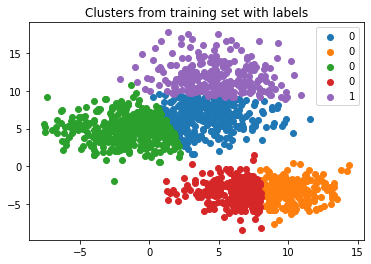

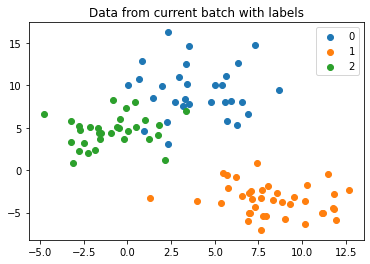

262it [01:05,  4.02it/s]


Time elapsed: 65.29865908622742


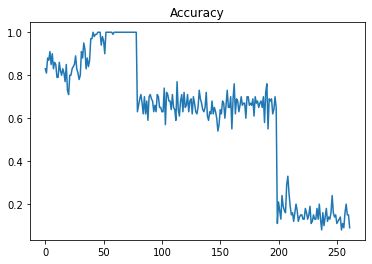

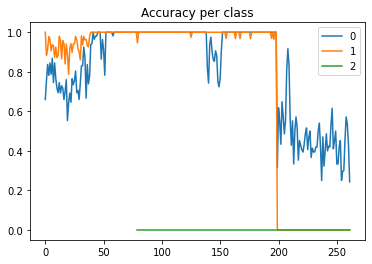

In [76]:
fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_2d, streaming_labels_2d, training_set_size=1500, print_interval=50, print_label_counts_in_clusters=True)

262it [00:53,  4.92it/s]


Time elapsed: 53.2342689037323


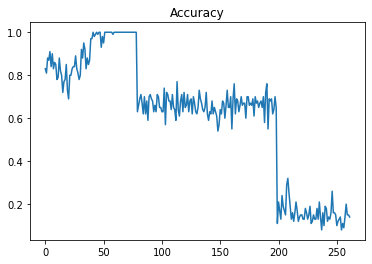

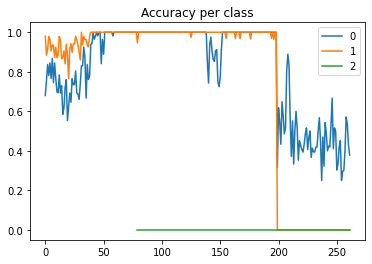

262it [00:54,  4.77it/s]


Time elapsed: 54.929948806762695


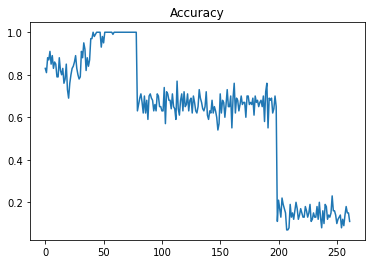

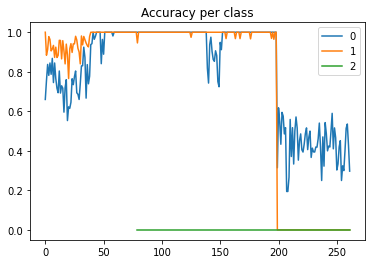

262it [00:53,  4.87it/s]


Time elapsed: 53.784099817276


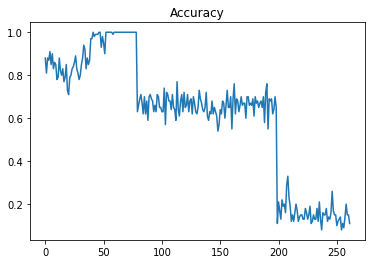

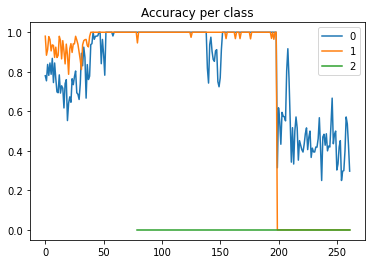

262it [00:54,  4.84it/s]


Time elapsed: 54.19078993797302


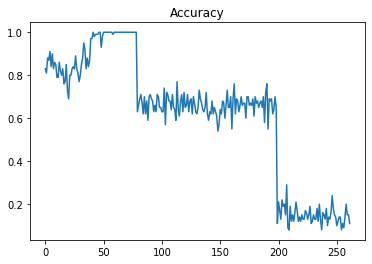

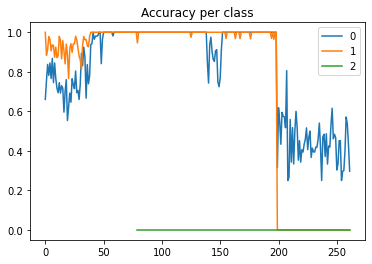

262it [00:53,  4.89it/s]


Time elapsed: 53.601048946380615


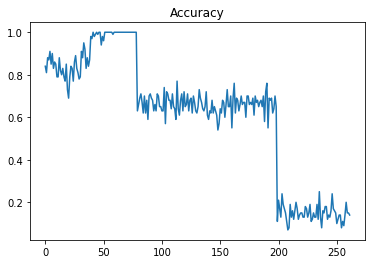

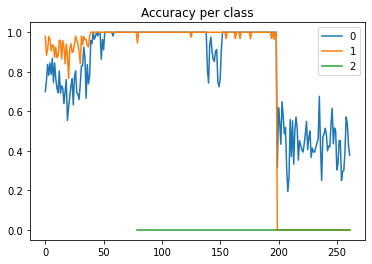

In [77]:
# Obtain averaged results
accuracy_results = []
accuracy_per_class_results = []
for i in range(5):
    fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_2d, streaming_labels_2d, training_set_size=1500, print_interval=1000, print_label_counts_in_clusters=False)
    accuracy_results.append(accuracies)
    accuracy_per_class_results.append(accuracies_per_class)

Text(0.5, 1.0, 'Accuracy averaged over 5 learning trials')

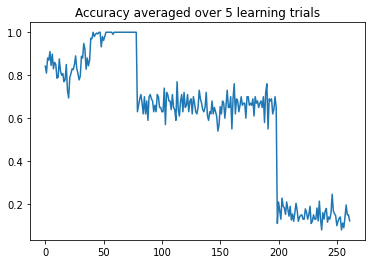

In [78]:
plt.plot(np.array(accuracy_results).mean(axis=0))
plt.title("Accuracy averaged over 5 learning trials")

In [79]:
avg_results_per_class = []
for class_ in range(3):
    result_per_class = np.array([dict_[class_] for dict_ in accuracy_per_class_results if class_ in dict_.keys()], dtype=float)
    avg_result_per_class = np.nanmean(result_per_class, axis=0)
    avg_results_per_class.append(avg_result_per_class)

<ipython-input-79-9865dfc5f3b5>:4: RuntimeWarning: Mean of empty slice
  avg_result_per_class = np.nanmean(result_per_class, axis=0)


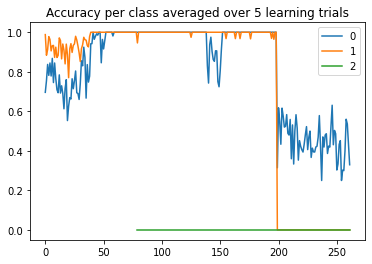

In [80]:
for class_ in range(3):
    plt.plot(avg_results_per_class[class_], label=class_)
    plt.legend()
    plt.title("Accuracy per class averaged over 5 learning trials")

# Experiments 3D

In [81]:
dataset_3d = "./3d_gaussian_data.csv"
gaussian_data_3d = pd.read_csv(dataset_3d)
y_3d = gaussian_data_3d.pop('label').to_numpy()
X_3d = gaussian_data_3d.to_numpy()

In [82]:
X_3d.shape

(20200, 3)

In [83]:
y_3d.shape

(20200,)

In [84]:
for xi, yi in stream.iter_array(X_3d, y_3d):
    print(xi, yi)
    break

{0: 8.065993314520647, 1: 2.252267979768172, 2: 5.110438424631312} 0


In [85]:
streaming_data_3d = np.split(X_3d, X_3d.shape[0]/100)
streaming_labels_3d = np.split(y_3d, y_3d.shape[0]/100)

In [86]:
streaming_data_3d[0].shape

(100, 3)

In [87]:
streaming_labels_3d[0].shape

(100,)

49it [00:10,  4.83it/s]

{0: 198, 1: 3}
{1: 33, 0: 498}
{0: 308}
{1: 204, 0: 4}
{0: 252}


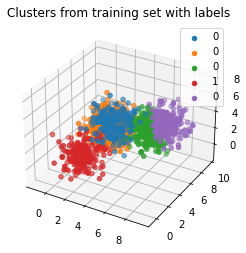

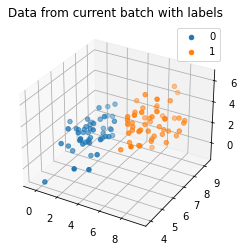

79it [00:17,  4.73it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


99it [00:21,  4.56it/s]

{0: 253}
{0: 399}
{0: 352}
{0: 238}
{0: 258}


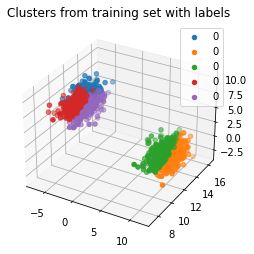

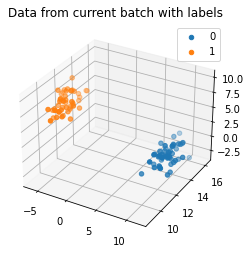

119it [00:25,  4.96it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


149it [00:32,  4.21it/s]

{0: 380}
{0: 291}
{0: 362}
{0: 218}
{0: 249}


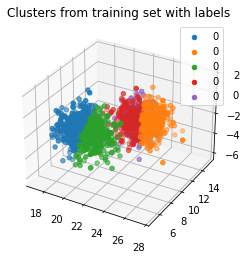

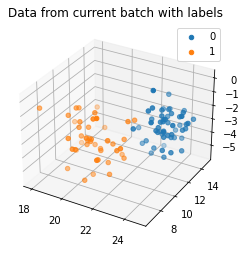

159it [00:35,  3.92it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


199it [00:43,  5.03it/s]

{0: 386}
{0: 268}
{0: 236}
{0: 249}
{0: 361}


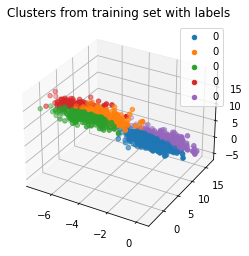

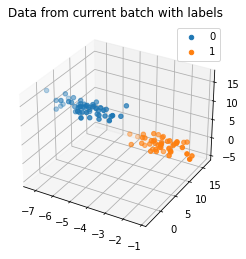

201it [00:44,  4.52it/s]


Time elapsed: 44.50297713279724


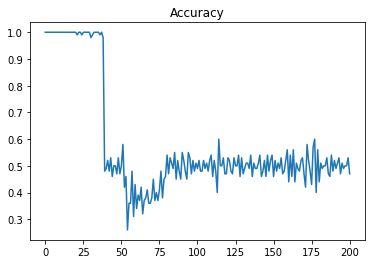

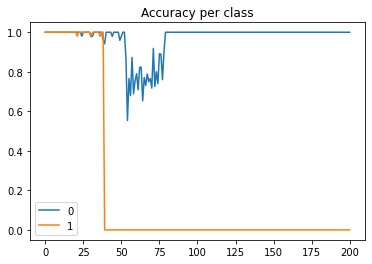

In [88]:
fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_3d, streaming_labels_3d, training_set_size=1500, print_interval=50, print_label_counts_in_clusters=True)

79it [00:16,  4.56it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


120it [00:25,  4.35it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


160it [00:34,  3.88it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


201it [00:41,  4.79it/s]


Time elapsed: 41.970155239105225


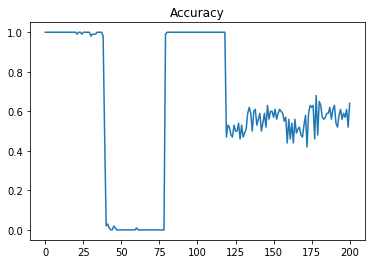

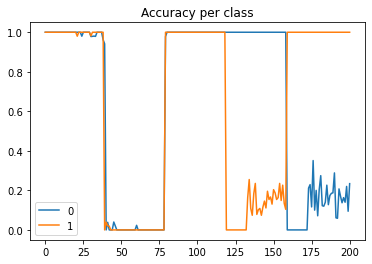

79it [00:17,  4.00it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


119it [00:27,  4.18it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


159it [00:37,  3.91it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


201it [00:47,  4.26it/s]

Time elapsed: 47.157947063446045


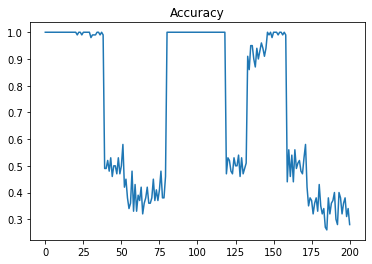

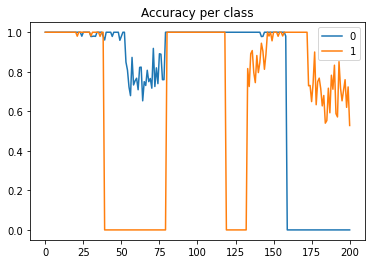

79it [00:16,  4.74it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


120it [00:24,  4.36it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


160it [00:33,  4.15it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


201it [00:41,  4.85it/s]


Time elapsed: 41.44012784957886


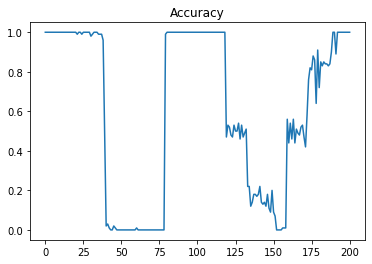

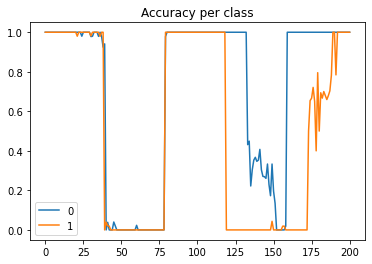

79it [00:17,  4.54it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


120it [00:25,  4.30it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


160it [00:34,  4.05it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


201it [00:42,  4.75it/s]

Time elapsed: 42.29592680931091


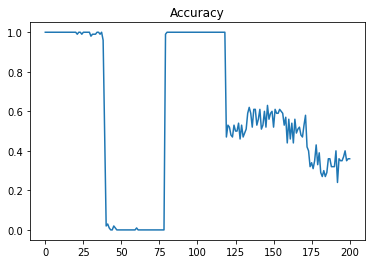

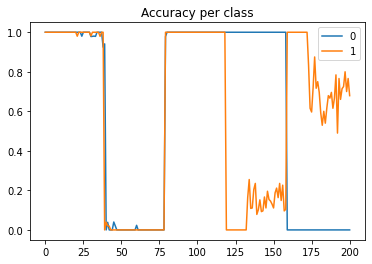

79it [00:17,  4.96it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


120it [00:25,  4.29it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


160it [00:34,  3.75it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


201it [00:42,  4.72it/s]


Time elapsed: 42.63561987876892


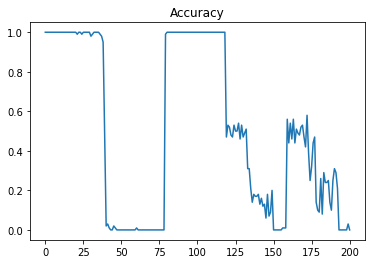

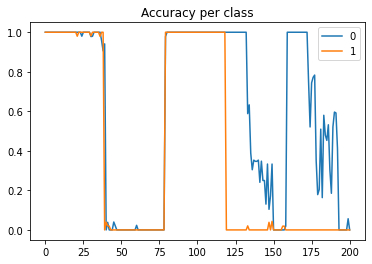

In [90]:
# Obtain averaged results
accuracy_results = []
accuracy_per_class_results = []
for i in range(5):
    fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_3d, streaming_labels_3d, training_set_size=1500, print_interval=1000, print_label_counts_in_clusters=False)
    accuracy_results.append(accuracies)
    accuracy_per_class_results.append(accuracies_per_class)

Text(0.5, 1.0, 'Accuracy averaged over 5 learning trials')

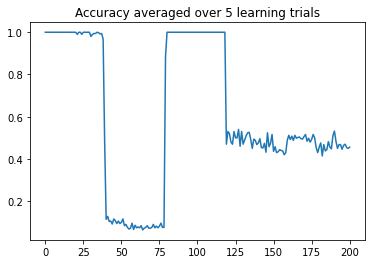

In [91]:
plt.plot(np.array(accuracy_results).mean(axis=0))
plt.title("Accuracy averaged over 5 learning trials")

In [92]:
avg_results_per_class = []
for class_ in range(2):
    result_per_class = np.array([dict_[class_] for dict_ in accuracy_per_class_results if class_ in dict_.keys()], dtype=float)
    avg_result_per_class = np.nanmean(result_per_class, axis=0)
    avg_results_per_class.append(avg_result_per_class)

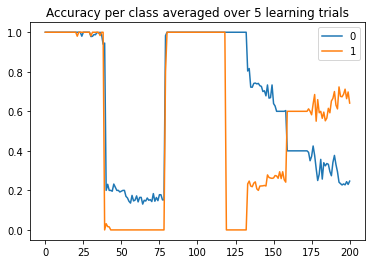

In [93]:
for class_ in range(2):
    plt.plot(avg_results_per_class[class_], label=class_)
    plt.legend()
    plt.title("Accuracy per class averaged over 5 learning trials")

# Experiments 3D with added class

In [94]:
dataset_3d = "./3d_gaussian_data_added_class.csv"
gaussian_data_3d = pd.read_csv(dataset_3d)
y_3d = gaussian_data_3d.pop('label').to_numpy()
X_3d = gaussian_data_3d.to_numpy()

In [95]:
X_3d.shape

(30300, 3)

In [96]:
y_3d.shape

(30300,)

In [97]:
for xi, yi in stream.iter_array(X_3d, y_3d):
    print(xi, yi)
    break

{0: -1.0151555241479664, 1: -1.4161182780401813, 2: 1.951098984742738} 1


In [98]:
streaming_data_3d = np.split(X_3d, X_3d.shape[0]/100)
streaming_labels_3d = np.split(y_3d, y_3d.shape[0]/100)

In [99]:
streaming_data_3d[0].shape

(100, 3)

In [100]:
streaming_labels_3d[0].shape

(100,)

49it [00:10,  4.56it/s]

{2: 260}
{1: 460, 2: 9}
{0: 237}
{2: 267, 1: 4}
{0: 259, 2: 2, 1: 2}


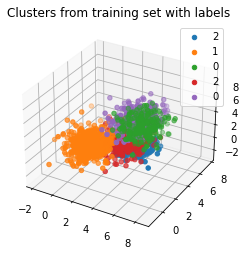

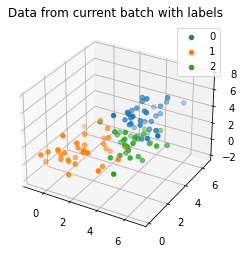

99it [00:21,  4.99it/s]

{0: 237}
{1: 484, 2: 2}
{2: 272}
{0: 268}
{2: 237}


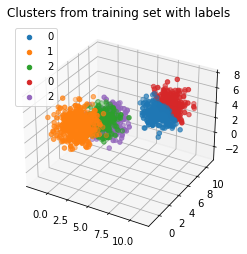

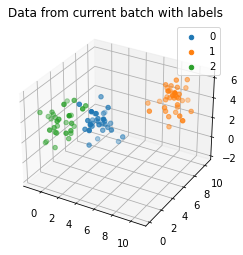

120it [00:26,  4.66it/s]

Number of clusters = 4
Number of clusters = 3


149it [00:31,  4.45it/s]

{2: 247}
{0: 259}
{1: 485, 0: 15}
{2: 262}
{0: 232}


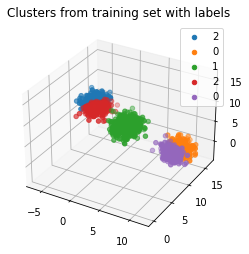

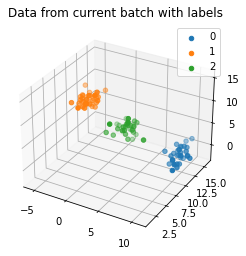

180it [00:38,  4.25it/s]

Number of clusters = 4
Number of clusters = 3


199it [00:42,  5.12it/s]

{1: 177, 2: 86}
{0: 233}
{0: 493}
{0: 274}
{1: 112, 2: 125}


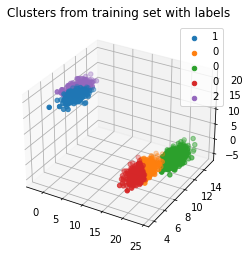

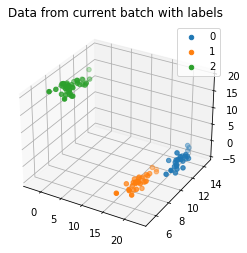

240it [00:50,  4.41it/s]

Number of clusters = 4
Number of clusters = 3


249it [00:52,  5.97it/s]

{1: 367}
{0: 272}
{1: 363, 0: 1}
{1: 369}
{1: 128}


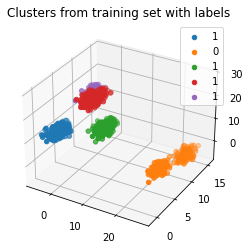

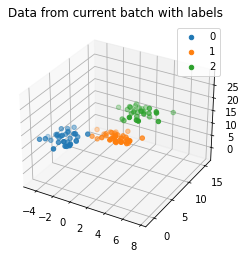

299it [01:02,  5.39it/s]

{1: 252}
{0: 498}
{1: 235}
{1: 265}
{1: 250}


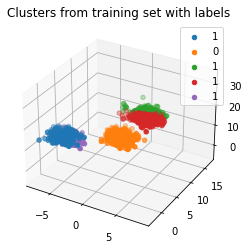

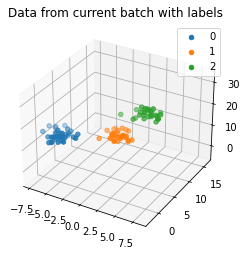

302it [01:03,  4.77it/s]


Time elapsed: 63.34663701057434


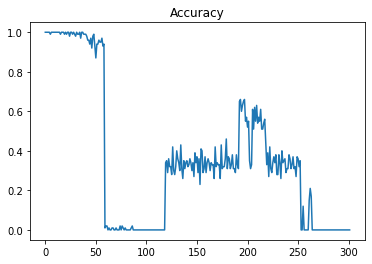

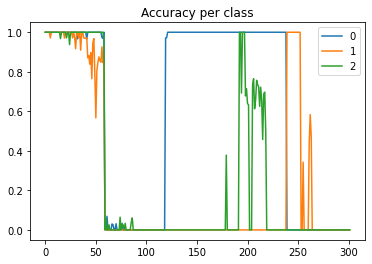

In [101]:
fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_3d, streaming_labels_3d, training_set_size=1500, print_interval=50, print_label_counts_in_clusters=True)

120it [00:25,  4.48it/s]

Number of clusters = 4
Number of clusters = 3


180it [00:37,  4.53it/s]

Number of clusters = 4
Number of clusters = 3


240it [00:48,  4.78it/s]

Number of clusters = 4
Number of clusters = 3


302it [01:00,  5.00it/s]

Time elapsed: 60.36815428733826


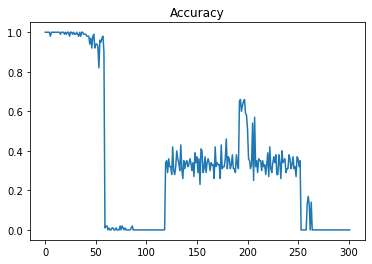

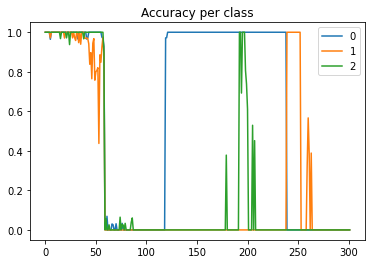

120it [00:26,  4.47it/s]

Number of clusters = 4
Number of clusters = 3


180it [00:38,  4.50it/s]

Number of clusters = 4
Number of clusters = 3


240it [00:50,  4.73it/s]

Number of clusters = 4
Number of clusters = 3


302it [01:01,  4.91it/s]


Time elapsed: 61.599196910858154


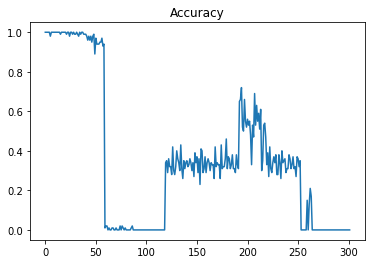

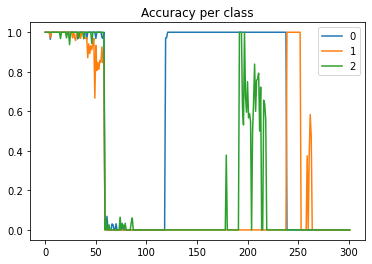

120it [00:25,  4.52it/s]

Number of clusters = 4
Number of clusters = 3


180it [00:36,  4.56it/s]

Number of clusters = 4
Number of clusters = 3


240it [00:48,  4.46it/s]

Number of clusters = 4
Number of clusters = 3


302it [01:00,  5.00it/s]


Time elapsed: 60.40419912338257


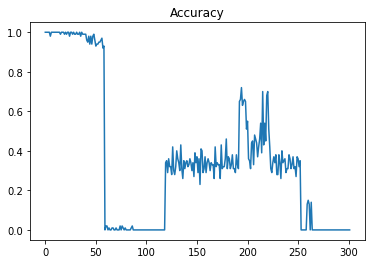

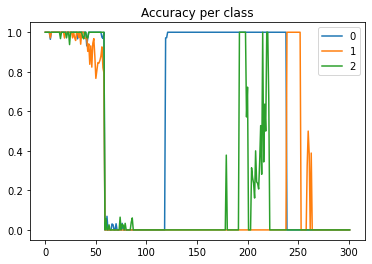

120it [00:24,  4.11it/s]

Number of clusters = 4
Number of clusters = 3


180it [00:35,  4.76it/s]

Number of clusters = 4
Number of clusters = 3


240it [00:46,  4.87it/s]

Number of clusters = 4
Number of clusters = 3


302it [00:57,  5.28it/s]


Time elapsed: 57.194509744644165


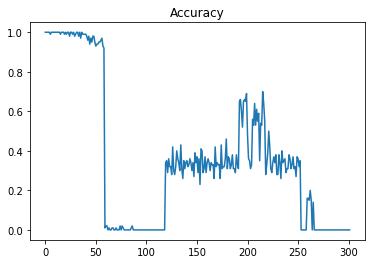

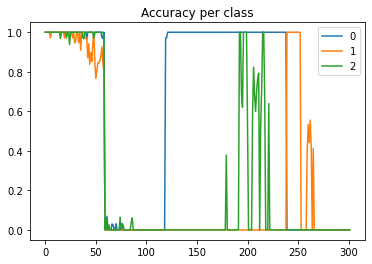

120it [00:24,  4.47it/s]

Number of clusters = 4
Number of clusters = 3


180it [00:35,  4.95it/s]

Number of clusters = 4
Number of clusters = 3


240it [00:46,  4.80it/s]

Number of clusters = 4
Number of clusters = 3


302it [00:58,  5.18it/s]


Time elapsed: 58.27096199989319


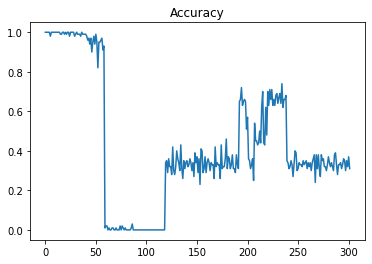

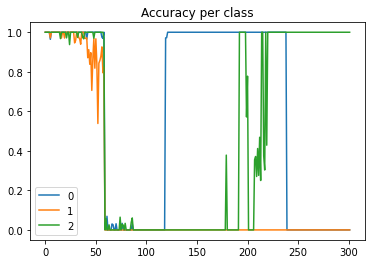

In [102]:
# Obtain averaged results
accuracy_results = []
accuracy_per_class_results = []
for i in range(5):
    fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_3d, streaming_labels_3d, training_set_size=1500, print_interval=1000, print_label_counts_in_clusters=False)
    accuracy_results.append(accuracies)
    accuracy_per_class_results.append(accuracies_per_class)

Text(0.5, 1.0, 'Accuracy averaged over 5 learning trials')

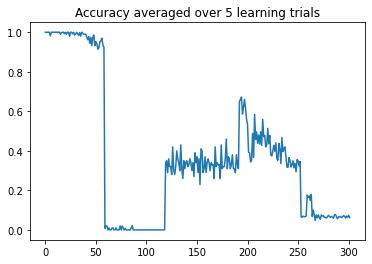

In [103]:
plt.plot(np.array(accuracy_results).mean(axis=0))
plt.title("Accuracy averaged over 5 learning trials")

In [104]:
avg_results_per_class = []
for class_ in range(3):
    result_per_class = np.array([dict_[class_] for dict_ in accuracy_per_class_results if class_ in dict_.keys()], dtype=float)
    avg_result_per_class = np.nanmean(result_per_class, axis=0)
    avg_results_per_class.append(avg_result_per_class)

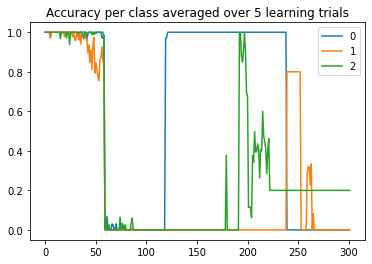

In [105]:
for class_ in range(3):
    plt.plot(avg_results_per_class[class_], label=class_)
    plt.legend()
    plt.title("Accuracy per class averaged over 5 learning trials")